# K-Means Clustering & PCA

## 데이터로드

In [1]:
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

customer = pd.read_excel("data/tables/customer.xlsx")
payment = pd.read_excel("data/tables/payment.xlsx")
order = pd.read_excel("data/tables/order.xlsx")
rfm = pd.read_excel("data/tables/rfm.xlsx")

print("customer 수: {}//payment 수: {}//rfm 수: {}//order 수: {}".format(len(customer),len(payment),len(rfm),len(order)))

customer 수: 1000//payment 수: 1184//rfm 수: 957//order 수: 2070


## Method1 : 고객 주소 및 RFM 군집

**테이블 합치기**

In [2]:
new_cus = pd.merge(rfm, customer, on = 'customer_id', how = 'left').dropna()
new_cus.head(5)

,customer_id,R,F,M,score,weight_score,address
0,0001,1,1,2,4,3.0,서울특별시 영등포구
1,0002,1,1,2,4,3.0,부산광역시 북구
2,0003,1,1,2,4,3.0,서울특별시 송파구
3,0005,1,1,2,4,3.0,서울특별시 서대문구
4,0006,1,1,2,4,3.0,경기도 김포시


**범주형 변수(주소) 수치로 정제**

In [3]:
city_name = new_cus['address'].value_counts().index
city_dict = dict(zip(city_name,range(1, len(city_name) + 1)))

new_cus['address_num'] = [city_dict[x] for x in new_cus['address']]
new_cus2 = new_cus.drop(['customer_id','address','score','R','F','M'],axis = 1)

**군집화**

In [4]:
kkk = KMeans(n_clusters = 5).fit(new_cus2)
new_cus2['cls'] = kkk.labels_
new_cus2.head()

,weight_score,address_num,cls
0,3.0,39,0
1,3.0,135,1
2,3.0,3,2
3,3.0,45,0
4,3.0,21,2


**시각화**

In [5]:
# 시각화를 위한 주성분 분석
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(new_cus2)

new_cus2['pca_x'] = pca_transformed[:,0]
new_cus2['pca_y'] = pca_transformed[:,1]

new_cus2.head()

,weight_score,address_num,cls,pca_x,pca_y
0,3.0,39,0,-19.676116,-1.832976
1,3.0,135,1,76.328297,-1.692262
2,3.0,3,2,-55.662132,-1.827533
3,3.0,45,0,-13.676252,-1.825713
4,3.0,21,2,-37.662539,-1.805744


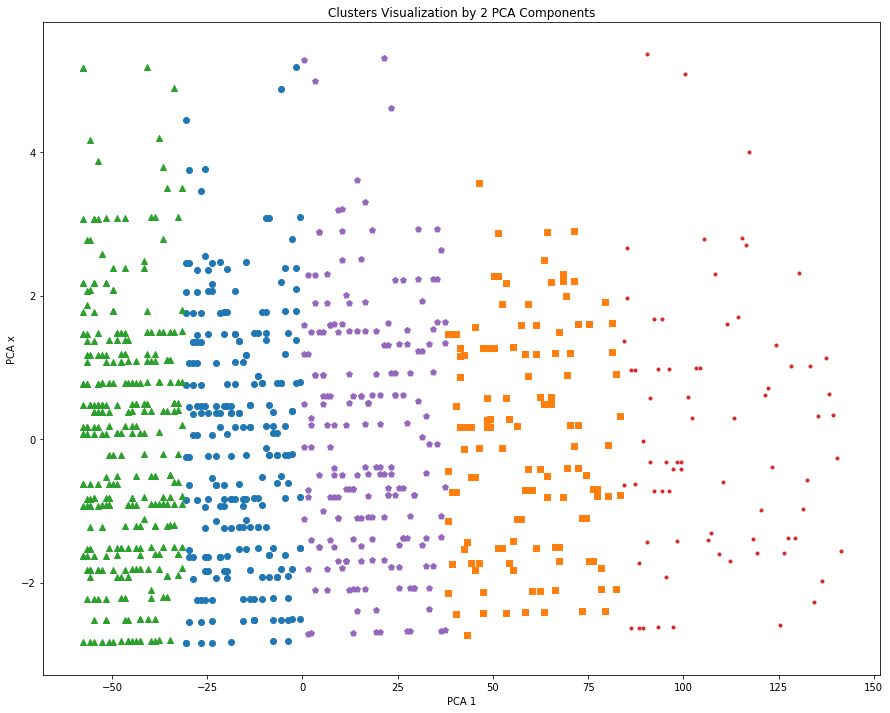

In [6]:
plt.figure(figsize = (15,12))
plt.scatter(new_cus2.loc[new_cus2.cls == 0, 'pca_x'], new_cus2.loc[new_cus2.cls == 0, 'pca_y'], marker = 'o')
plt.scatter(new_cus2.loc[new_cus2.cls == 1, 'pca_x'], new_cus2.loc[new_cus2.cls == 1, 'pca_y'], marker = 's')
plt.scatter(new_cus2.loc[new_cus2.cls == 2, 'pca_x'], new_cus2.loc[new_cus2.cls == 2, 'pca_y'], marker = '^')
plt.scatter(new_cus2.loc[new_cus2.cls == 3, 'pca_x'], new_cus2.loc[new_cus2.cls == 3, 'pca_y'], marker = '.')
plt.scatter(new_cus2.loc[new_cus2.cls == 4, 'pca_x'], new_cus2.loc[new_cus2.cls == 4, 'pca_y'], marker = 'p')

plt.xlabel('PCA 1')
plt.ylabel('PCA x')

plt.title('Clusters Visualization by 2 PCA Components')
plt.show()

- RFM 모델에서 이미 군집이 되어 있기 때문에 위와 같이 나온 것으로 추정
- 변수 몇 개 조정해야 함

---

## Method2 : order, payment 군집화

**테이블 합치기**

In [7]:
data = pd.merge(order, payment, on = ['customer_id','date','pay_check'], how = 'left')
print(len(data))
data.head(2)

2100


,customer_id,order_num,date,product_num,order_count,pay_check,order_price,payment_price,payment_method,coupon,reserve_fund
0,0001,20191001-0000015-01,2019-10-01 12:26:38,1,1,T,59900,29950,선불금,not_used,not_used
1,0002,20191001-0000026-01,2019-10-01 15:31:44,2,1,T,59900,29950,신용카드,not_used,not_used


**범주형 변수 수치화**

In [8]:
# 결제 수단 사전화
method_list = data['payment_method'].value_counts().index
method_dict = dict(zip(method_list,range(1,len(method_list)+1)))
method_dict

{'신용카드': 1, '무통장입금': 2, '선불금': 3, '휴대폰': 4, '계좌이체': 5, '적립금만_결제': 6}

In [9]:
# 결측치 제거 및 쿠폰, 적립금 변수 등 수치화
data = data[data['customer_id'] != 'None']
data2 = data.copy()

data2['pay_check'] = [1 if x == 'T' else 0 for x in data['pay_check']]
data2['coupon'] = [1 if x == 'used' else 0 for x in data['coupon']]
data2['reserve_fund'] = [1 if x == 'used' else 0 for x in data['reserve_fund']]
data2['payment_method'] = [method_dict[x] for x in data['payment_method']]

data2.drop(['customer_id','date','order_num','order_price'],axis = 1,inplace = True)
data2.head(2)

,product_num,order_count,pay_check,payment_price,payment_method,coupon,reserve_fund
0,1,1,1,29950,3,0,0
1,2,1,1,29950,1,0,0


**상관도 탐색**

In [11]:
data3 = data2.drop(['product_num',])

7

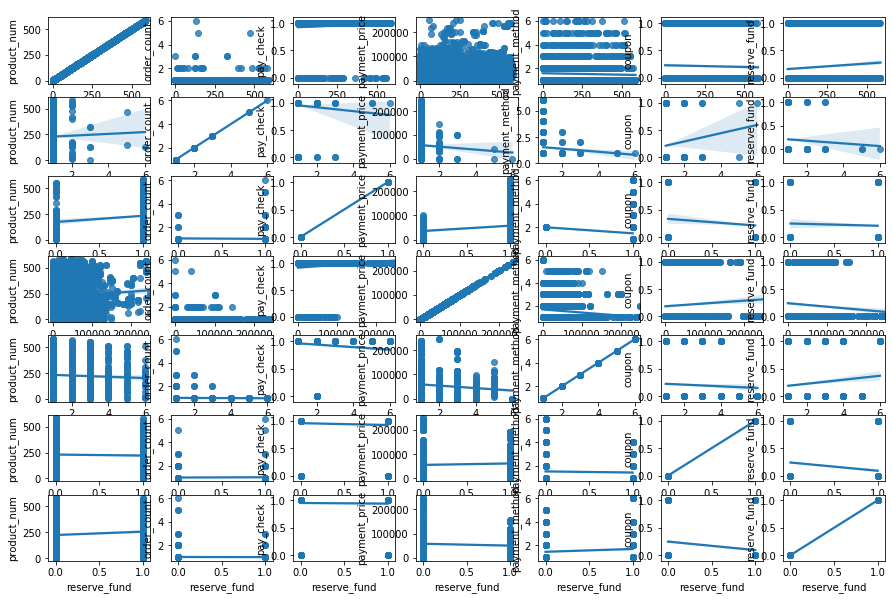

In [13]:
import seaborn as sns

plt.figure(figsize = (15,10))
n = 0
for x in data2.columns:
    for y in data2.columns:
        n += 1
        plt.subplot(7,7,n)
        sns.regplot(x = x, y = y, data = data2)
        
plt.show()

**군집화**

[갈아엎기](http://blog.naver.com/PostView.nhn?blogId=samsjang&logNo=221017639342&categoryNo=0&parentCategoryNo=49&viewDate=&currentPage=1&postListTopCurrentPage=1&from=search)

In [56]:
data_k = KMeans(n_clusters = 5).fit(data2)
data2 ['cls'] = data_k.labels_
data2.head(5)

,customer_id,product_num,order_count,pay_check,payment_price,payment_method,coupon,reserve_fund,cls
0,0001,1,1,1,29950,3,0,0,4
1,0002,2,1,1,29950,1,0,0,4
2,0003,3,1,1,29950,1,0,0,4
3,0004,4,1,0,0,2,0,0,0
4,0004,4,1,0,71840,2,0,0,2


**시각화**

In [57]:
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(data2)

data2['pca_x'] = pca_transformed[:,0]
data2['pca_y'] = pca_transformed[:,1]

data2.head()

,customer_id,product_num,order_count,pay_check,payment_price,payment_method,coupon,reserve_fund,cls,pca_x,pca_y
0,0001,1,1,1,29950,3,0,0,4,-26548.683697,-539.788682
1,0002,2,1,1,29950,1,0,0,4,-26548.683453,-538.493693
2,0003,3,1,1,29950,1,0,0,4,-26548.683215,-537.198778
3,0004,4,1,0,0,2,0,0,0,-56498.681847,-533.931622
4,0004,4,1,0,71840,2,0,0,2,15341.315409,-538.662960


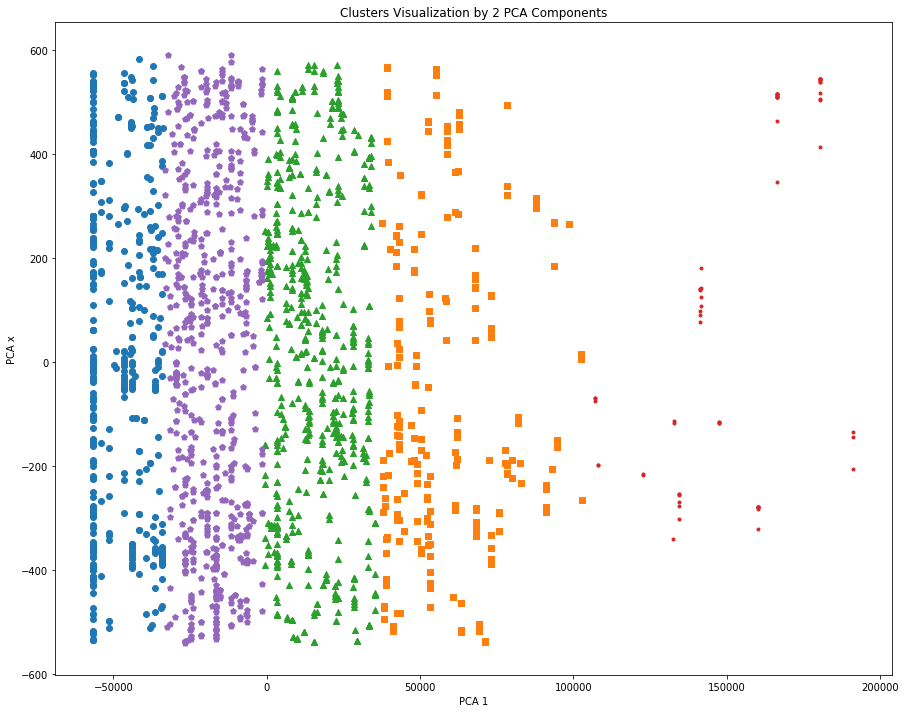

In [58]:
plt.figure(figsize = (15,12))
plt.scatter(data2.loc[data2.cls == 0, 'pca_x'], data2.loc[data2.cls == 0, 'pca_y'], marker = 'o')
plt.scatter(data2.loc[data2.cls == 1, 'pca_x'], data2.loc[data2.cls == 1, 'pca_y'], marker = 's')
plt.scatter(data2.loc[data2.cls == 2, 'pca_x'], data2.loc[data2.cls == 2, 'pca_y'], marker = '^')
plt.scatter(data2.loc[data2.cls == 3, 'pca_x'], data2.loc[data2.cls == 3, 'pca_y'], marker = '.')
plt.scatter(data2.loc[data2.cls == 4, 'pca_x'], data2.loc[data2.cls == 4, 'pca_y'], marker = 'p')

plt.xlabel('PCA 1')
plt.ylabel('PCA x')

plt.title('Clusters Visualization by 2 PCA Components')
plt.show()